# Detecting Panic Disorder

Author: **Marcin Sikorski**<br>
Date: June, 2023

**Introduction**<br>
Panic disorder is an anxiety disorder where one has regular, sudden, and unexcepted attacks of panic or fear. While it is normal for human beings to experience anxiety and panic at certain times, patients with panic disorder have feelings of stress and panic regularly and at any time, often for no apparent reason. These episodes make their lives overwhelming and decrease their overall comfort.

The cause of panic disorder is unknown. Risk factors include child abuse, drug use, psychological stress, and maybe genetics. Some of the symptoms of panic attacks are chills, sweating, chest pain, nausea, shortness of breath, dizziness, etc.

**Motivation**<br>
The main motive behind this study is to develop accurate models or frameworks for detecting panic disorder. Based on collected symptoms and demographic data of respondents we will perform a binary classification. The dataset for this notebook was found on [Kaggle](https://www.kaggle.com/datasets/muhammadshahidazeem/panic-disorder-detection-dataset). It contains two CSV files for both training and testing.

**Notebook Content:**
1. Importing Dataset<br>
2. Relationship Exploration<br>
3. Encoding Categorical Values<br>
4. Standardizing and Splitting Data<br>
5. Model Training<br>
6. Evaluating Model Performance<br>
7. Conclusions

### 1. Importing Dataset

The datasets are in a ZIP file in CSV format. We will concate them into one dataframe and shuffle the rows. Next, we will summarize the dataframe by searching for: data type, null values and number of unique labels.

In [1]:
import pandas as pd
import numpy as np

# import data from ZIP file and create dataframe
def load_dataset():
    import zipfile
    with zipfile.ZipFile('archive.zip') as z_file:
        file_1 = z_file.open('panic_disorder_dataset_training.csv')
        file_2 = z_file.open('panic_disorder_dataset_testing.csv')
    
        data_1 = pd.read_csv(file_1, header=0, encoding='utf-8')
        data_2 = pd.read_csv(file_2, header=0, encoding='utf-8')
    
        # concate datasets
        concate_data = pd.concat([data_1, data_2])
    
        # remove duplicated rows
        df = concate_data.drop_duplicates()
    
        # shuffle rows
        df = df.sample(frac=1)
    return df

df = load_dataset()

# display first rows
df.head()

,Participant ID,Age,Gender,Family History,Personal History,Current Stressors,Symptoms,Severity,Impact on Life,Demographics,Medical History,Psychiatric History,Substance Use,Coping Mechanisms,Social Support,Lifestyle Factors,Panic Disorder Diagnosis
7812,7813,46,Male,No,Yes,Low,Shortness of breath,Severe,Significant,Rural,None,Anxiety disorder,Alcohol,Exercise,Moderate,Diet,0
49038,49039,58,Female,Yes,No,Moderate,Chest pain,Severe,Moderate,Urban,Diabetes,Anxiety disorder,Alcohol,Exercise,Low,Diet,0
60517,60518,33,Male,No,Yes,Low,Shortness of breath,Mild,Significant,Urban,Diabetes,Anxiety disorder,Drugs,Exercise,High,Exercise,0
29625,29626,22,Male,No,Yes,High,Panic attacks,Severe,Mild,Rural,Diabetes,Depressive disorder,Alcohol,Meditation,Low,Sleep quality,1
61384,61385,62,Female,Yes,No,Low,Panic attacks,Moderate,Significant,Urban,Asthma,Depressive disorder,Alcohol,Seeking therapy,Low,Sleep quality,1


In [2]:
# display data type, count null values, and unique values for each column
def columns_summary():  
    # empty lists
    col_list = df.columns.to_list()
    dtype_list = []
    null_list = []
    unique_list = []
    
    for col in df.columns:
        dtype_list.append(df[col].dtype)
        null_list.append(df[col].isnull().sum())
        unique_list.append(df[col].nunique())
    
    # stack lists into dataframe
    df_sum = pd.DataFrame(list(zip(col_list, dtype_list, null_list, unique_list)),
                      columns = ['Feature', 'Data type', 'Null values', 'Unique values'])
    
    return df_sum.style.hide(axis='index')
    
columns_summary()

Feature,Data type,Null values,Unique values
Participant ID,int64,0,100000
Age,int64,0,48
Gender,object,0,2
Family History,object,0,2
Personal History,object,0,2
Current Stressors,object,0,3
Symptoms,object,0,5
Severity,object,0,3
Impact on Life,object,0,3
Demographics,object,0,2


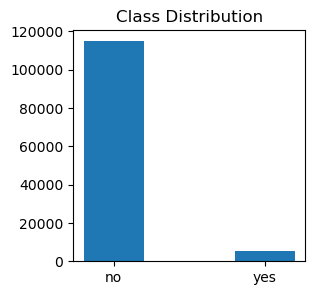

In [3]:
import matplotlib.pyplot as plt

# plot target distribution
def count_target():
    values = df['Panic Disorder Diagnosis'].value_counts().tolist()
    
    plt.figure(figsize=(3, 3))
    plt.bar(x=['no', 'yes'], height=values, width=0.4)
    plt.title('Class Distribution')
    plt.show()
    
count_target()

The target distribution is very imbalanced.

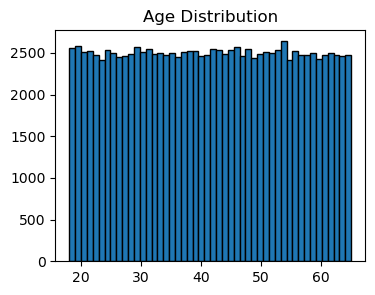

In [4]:
# plot age distribution
def plot_histogram():
    plt.figure(figsize=(4, 3))
    plt.hist(x=df['Age'], bins=48, edgecolor='black')
    plt.title('Age Distribution')
    plt.show()

plot_histogram()

This column has no visible trends and no outliers. This feature looks balanced in terms of distribution and is probably neutral.

### 2. Relationship Exploration

For nominal (categorical) data we will perform the chi square statistical test ($\chi^{2}$) to find relationships with target column. For the only one continuous feature we will do the point biserial test. This test also checks P-value for any statistical significance.

In [5]:
# checking for statistical relationships with categorical predictors
def chi2_test():
    from scipy.stats import chi2_contingency
    
    # nominal predictors
    categ_features = ['Gender', 'Family History', 'Personal History', 'Current Stressors', 'Symptoms', 'Severity',
                      'Impact on Life', 'Demographics', 'Medical History', 'Psychiatric History','Substance Use',
                      'Coping Mechanisms', 'Social Support', 'Lifestyle Factors']
    
    # empty lists
    ch2_list = []
    p_val_list = []
    
    for col in categ_features:
        cross_tab = pd.crosstab(index=df['Panic Disorder Diagnosis'], columns=df[col])
        chi2_results = chi2_contingency(cross_tab)
        
        # if the p-value is < 0.05, that means we reject H0
        # 0 - not correlated
        # 1 - correlated
        if (chi2_results[1] < 0.05):
            ch2_list.append(1)
        else:
            ch2_list.append(0)
        
        p_val_list.append(chi2_results[1])
        
    # stack lists into dataframe
    df_sum = pd.DataFrame(list(zip(categ_features, ch2_list, p_val_list)), columns = ['Feature', 'Correlation', 'P-value'])
    
    return df_sum.style.hide(axis='index')

chi2_test()

Feature,Correlation,P-value
Gender,0,0.860432
Family History,1,0.000000
Personal History,1,0.000000
Current Stressors,1,0.000000
Symptoms,1,0.000000
Severity,1,0.000000
Impact on Life,1,0.000000
Demographics,1,0.000000
Medical History,1,0.000000
Psychiatric History,1,0.000000


In [6]:
# point biserial test: Pearson corr and P-value
def point_biserial_test():
    from scipy.stats import pointbiserialr

    corr, p_value = pointbiserialr(df['Age'], df['Panic Disorder Diagnosis'])
    
    return p_value

point_biserial_test()

0.9372224643518221

It looks like both <code>Gender</code> and <code>Age</code> are neutral predictors for detecting panic disorder.

### 3. Encoding Categorical Values

Almost all columns contain categorical labels stored as text values and they need to be set as integers. We will create a dictionary to map the categorical values with their new corresponding integers.

In [7]:
# mapping dictionary
mapping_dict = dict()
    
# display labels for each category and new integer
def encode_features():
    categ_features = ['Gender', 'Family History', 'Personal History', 'Current Stressors', 'Symptoms', 'Severity',
                      'Impact on Life', 'Demographics', 'Medical History', 'Psychiatric History','Substance Use',
                      'Coping Mechanisms', 'Social Support', 'Lifestyle Factors']
    
    for col in categ_features:
        unique_values = df[col].unique()
        print('='*40)
        print(f'Category: {col}')
        
        for i, value in enumerate(unique_values):
            mapping_dict[value] = i
            category = value
            print(f'label: {category} ({i})')

encode_features()

# apply/replace into new values
df = df.replace(mapping_dict)

Category: Gender
label: Male (0)
label: Female (1)
Category: Family History
label: No (0)
label: Yes (1)
Category: Personal History
label: Yes (0)
label: No (1)
Category: Current Stressors
label: Low (0)
label: Moderate (1)
label: High (2)
Category: Symptoms
label: Shortness of breath (0)
label: Chest pain (1)
label: Panic attacks (2)
label: Fear of losing control (3)
label: Dizziness (4)
Category: Severity
label: Severe (0)
label: Mild (1)
label: Moderate (2)
Category: Impact on Life
label: Significant (0)
label: Moderate (1)
label: Mild (2)
Category: Demographics
label: Rural (0)
label: Urban (1)
Category: Medical History
label: None (0)
label: Diabetes (1)
label: Asthma (2)
label: Heart disease (3)
Category: Psychiatric History
label: Anxiety disorder (0)
label: Depressive disorder (1)
label: None (2)
label: Bipolar disorder (3)
Category: Substance Use
label: Alcohol (0)
label: Drugs (1)
label: None (2)
Category: Coping Mechanisms
label: Exercise (0)
label: Meditation (1)
label: See

### 4. Standardizing and Splitting Data

We will standardize each feature by removing the mean and scaling to unit variance. The column <code>Participant ID</code> will be dropped. Lastly, we will partion our dataset into training and validation sets and accept a 70:30 ratio.

In [8]:
# standardize and split data
def standardize_split_data():
    from sklearn.model_selection import train_test_split
    
    # features for X array
    features = df.drop(['Participant ID', 'Panic Disorder Diagnosis'], axis=1)
    
    global X, y, X_train, X_test, y_train, y_test
    
    # rescale data - feature array X
    X = (features - np.mean(features, axis=0)) / (np.std(features, axis=0)).values
    # target data y
    y = df['Panic Disorder Diagnosis'].values
    
    # partion data
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=0)
    
    # display number of samples per set
    print('Train Data:', len(X_train))
    print('Test Data:', len(X_test))
    
standardize_split_data()

Train Data: 84000
Test Data: 36000


### 5. Model Training

We will train seven different machine learning models, including an artificial neural network, and evaluate their performance with basic classification scores.

In [9]:
# dictionaries for storing metrics
accuracies = dict()
f1_scores = dict()
precision_scores = dict()
recall_scores = dict()
auc_scores = dict()
true_negatives = dict()
false_positives = dict()
false_negatives = dict()
true_positives = dict()
matthews_corrcoefs = dict()
classifiers = ['SVM', 'RF', 'LR', 'XBG', 'KNN', 'SGD']

def ml_classification():
    from sklearn.svm import SVC
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.linear_model import LogisticRegression
    from xgboost import XGBClassifier
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.linear_model import SGDClassifier
    
    from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
    from sklearn.metrics import roc_curve, auc, confusion_matrix, matthews_corrcoef
    
    # initialize lists
    classifier_list = [SVC(kernel='linear'), RandomForestClassifier(), LogisticRegression(),
                       XGBClassifier(), KNeighborsClassifier(), SGDClassifier()]
    
    def perform_classification(classifier, code):
        clf = classifier.fit(X_train, y_train)
        
        # predict new labels
        y_pred = clf.predict(X_test)
        
        # append scores into dictionaries
        accuracies[code] = accuracy_score(y_test, y_pred)
        f1_scores[code] = f1_score(y_test, y_pred, zero_division=0)
        precision_scores[code] = precision_score(y_test, y_pred, zero_division=0)
        recall_scores[code] = recall_score(y_test, y_pred, zero_division=0)
        
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        auc_scores[code] = auc(fpr, tpr)
        
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        true_negatives[code] = tn
        false_positives[code] = fp
        false_negatives[code] = fn
        true_positives[code] = tp
        
        matthews_corrcoefs[code] = matthews_corrcoef(y_test, y_pred)
        
        print('Obtained accuracy for {}: {:.6f}'.format(code, accuracy_score(y_test, y_pred)))
    
    # run classification on chosen algorithms
    for clf_, init in zip(classifier_list, classifiers):
        perform_classification(classifier=clf_, code=init)
        
ml_classification()

Obtained accuracy for SVM: 0.958611
Obtained accuracy for RF: 0.965667
Obtained accuracy for LR: 0.960694
Obtained accuracy for XBG: 0.967833
Obtained accuracy for KNN: 0.959028
Obtained accuracy for SGD: 0.958611


In [10]:
def ann_classification():
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense
    
    from tensorflow.keras.metrics import BinaryAccuracy
    from tensorflow.keras.optimizers import Adam
    
    # construct classifier
    classifier = Sequential(
        [
            Dense(units=9, kernel_initializer='he_uniform', activation='relu', input_dim=np.shape(X_train)[1]),
            Dense(units=9, kernel_initializer='he_uniform', activation='relu'),
            Dense(units=1, kernel_initializer='glorot_uniform', activation='sigmoid')
        ]
        )
    
    # define Adam optimizer and compile model
    adam_opt = Adam(learning_rate=0.001)
    classifier.compile(optimizer=adam_opt, loss='binary_crossentropy', metrics=[BinaryAccuracy(name='accuracy')])
    
    code = 'ANN'
    classifiers.append(code)
    
    # fit model
    history = classifier.fit(X_train, y_train, batch_size=100, epochs=100, verbose=0)
    
    # predict new labels
    predictions = classifier.predict(X_test)
    y_pred = predictions > 0.5
    
    from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
    from sklearn.metrics import roc_curve, auc, confusion_matrix, matthews_corrcoef
    
    # append scores into dictionaries
    accuracies[code] = accuracy_score(y_test, y_pred)
    f1_scores[code] = f1_score(y_test, y_pred, zero_division=0)
    precision_scores[code] = precision_score(y_test, y_pred, zero_division=0)
    recall_scores[code] = recall_score(y_test, y_pred, zero_division=0)
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    auc_scores[code] = auc(fpr, tpr)
    
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    true_negatives[code] = tn
    false_positives[code] = fp
    false_negatives[code] = fn
    true_positives[code] = tp
    
    matthews_corrcoefs[code] = matthews_corrcoef(y_test, y_pred)
    
    print('Obtained accuracy for {}: {:.6f}'.format(code, accuracy_score(y_test, y_pred)))
    
ann_classification()

1125/1125 [==============================] - 2s 2ms/step
Obtained accuracy for ANN: 0.965139


### 6. Evaluating Model Performance

All selected models trained with promising accuracies. We will check and overview other metrics to study their performance.

In [11]:
# display measures in tabular form
def display_results():
    # index list
    metrics = ['Accuracy', 'F1-score', 'Precision', 'Recall', 'AUC', 'TN', 'FP', 'FN', 'TP', 'MCC']

    df = pd.DataFrame(data=[accuracies, f1_scores, precision_scores, recall_scores,
                            auc_scores, true_negatives, false_positives, false_negatives,
                            true_positives, matthews_corrcoefs], index=metrics)
    
    return df

display_results()

,SVM,RF,LR,XBG,KNN,SGD,ANN
Accuracy,0.958611,0.965667,0.960694,0.967833,0.959028,0.958611,0.965139
F1-score,0.000000,0.476271,0.242100,0.599030,0.288471,0.000000,0.476865
Precision,0.000000,0.645977,0.599469,0.618741,0.512864,0.000000,0.629263
Recall,0.000000,0.377181,0.151678,0.580537,0.200671,0.000000,0.383893
AUC,0.500000,0.684128,0.573651,0.782546,0.596221,0.500000,0.687064
TN,34510.000000,34202.000000,34359.000000,33977.000000,34226.000000,34510.000000,34173.000000
FP,0.000000,308.000000,151.000000,533.000000,284.000000,0.000000,337.000000
FN,1490.000000,928.000000,1264.000000,625.000000,1191.000000,1490.000000,918.000000
TP,0.000000,562.000000,226.000000,865.000000,299.000000,0.000000,572.000000
MCC,0.000000,0.477658,0.288230,0.582614,0.303686,0.000000,0.475013


Accuracy is the mostly widely used measure to summarize the performance of a classification model but we can see it is not always the best one. All classifiers achieved minimum 95% which is a very high score. For imbalanced data the other metrics are better for assessing.

Based on AUC values (areas under curves) the SVM and SGD are not good classifiers and make random guesses. The true negatives and true positives are 0. This causes F1 and MCC scores (Matthews correlation coefficient) to be also 0 (or very close). The models do not perform well with class imbalance and need applying class weights.

By taking into account both the accuracy and MCC the best model for this dataset is the XGBoost. RF is also a great choice with slightly lower performance.

In [12]:
# retrain SVM and SGD models with class weights and update dictionaries
def update_classification():
    from sklearn.utils.class_weight import compute_sample_weight
    from sklearn.svm import SVC
    from sklearn.linear_model import SGDClassifier
    
    from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
    from sklearn.metrics import roc_curve, auc, confusion_matrix, matthews_corrcoef
    
    # calculate weights for each class
    def extract_class_weights():
        classes = df['Panic Disorder Diagnosis'].unique()
        weights = compute_sample_weight(class_weight='balanced', y=df['Panic Disorder Diagnosis'])
    
        return dict(zip(classes, np.unique(weights)))
    
    class_weights = extract_class_weights()
    
    # initialize lists
    classifier_list = [SVC(kernel='linear', class_weight=class_weights), SGDClassifier(class_weight=class_weights)]
    codes = ['SVM', 'SGD']
    
    accuracies_ = dict()
    f1_scores_ = dict()
    precision_scores_ = dict()
    recall_scores_ = dict()
    auc_scores_ = dict()
    true_negatives_ = dict()
    false_positives_ = dict()
    false_negatives_ = dict()
    true_positives_ = dict()
    matthews_corrcoefs_ = dict()
    
    def perform_classification(classifier, code):
        clf = classifier.fit(X_train, y_train)
        
        # predict new labels
        y_pred = clf.predict(X_test)
        
        # append scores into dictionaries
        accuracies_[code] = accuracy_score(y_test, y_pred)
        f1_scores_[code] = f1_score(y_test, y_pred, zero_division=0)
        precision_scores_[code] = precision_score(y_test, y_pred, zero_division=0)
        recall_scores_[code] = recall_score(y_test, y_pred, zero_division=0)
        
        fpr, tpr, thresholds = roc_curve(y_test, y_pred)
        auc_scores_[code] = auc(fpr, tpr)
        
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        true_negatives_[code] = tn
        false_positives_[code] = fp
        false_negatives_[code] = fn
        true_positives_[code] = tp
        
        matthews_corrcoefs_[code] = matthews_corrcoef(y_test, y_pred)
        
        print(f'{code} updated')
        
    # run classification on chosen algorithms
    for clf_, init in zip(classifier_list, codes):
        perform_classification(classifier=clf_, code=init)
    
    # update dictionaries
    accuracies.update(accuracies_)
    f1_scores.update(f1_scores_)
    precision_scores.update(precision_scores_)
    recall_scores.update(recall_scores_)
    auc_scores.update(auc_scores_)
    true_negatives.update(true_negatives_)
    false_positives.update(false_positives_)
    false_negatives.update(false_negatives_)
    true_positives.update(true_positives_)
    matthews_corrcoefs.update(matthews_corrcoefs_)   
    
    # index list
    metrics = ['Accuracy', 'F1-score', 'Precision', 'Recall', 'AUC', 'TN', 'FP', 'FN', 'TP', 'MCC']
    
    measures = pd.DataFrame(data=[accuracies, f1_scores, precision_scores, recall_scores,
                                  auc_scores, true_negatives, false_positives, false_negatives,
                                  true_positives, matthews_corrcoefs], index=metrics)
    
    return measures

update_classification()

SVM updated
SGD updated


,SVM,RF,LR,XBG,KNN,SGD,ANN
Accuracy,0.817111,0.965667,0.960694,0.967833,0.959028,0.843556,0.965139
F1-score,0.303575,0.476271,0.242100,0.599030,0.288471,0.325670,0.476865
Precision,0.180186,0.645977,0.599469,0.618741,0.512864,0.198193,0.629263
Recall,0.963087,0.377181,0.151678,0.580537,0.200671,0.912752,0.383893
AUC,0.886948,0.684128,0.573651,0.782546,0.596221,0.876660,0.687064
TN,27981.000000,34202.000000,34359.000000,33977.000000,34226.000000,29008.000000,34173.000000
FP,6529.000000,308.000000,151.000000,533.000000,284.000000,5502.000000,337.000000
FN,55.000000,928.000000,1264.000000,625.000000,1191.000000,130.000000,918.000000
TP,1435.000000,562.000000,226.000000,865.000000,299.000000,1360.000000,572.000000
MCC,0.371385,0.477658,0.288230,0.582614,0.303686,0.382023,0.475013


Although the accuracies of these two updated models decreased the other measures significantly improved. Still, the gradient boosting classifier is the best choice upon all. We will check and display which features are most useful to detect panic disorder.

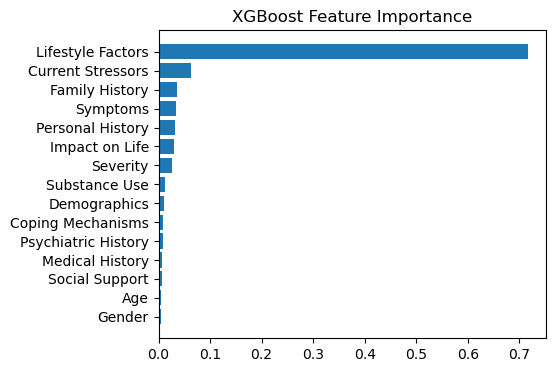

In [13]:
# plot feature importance for best model
def plot_feature_importance():
    from xgboost import XGBClassifier
    
    clf = XGBClassifier().fit(X_train, y_train)
    
    sorted_idx = clf.feature_importances_.argsort()
    
    plt.figure(figsize=(5, 4))
    plt.barh(y=X.columns[sorted_idx], width=clf.feature_importances_[sorted_idx])
    plt.title('XGBoost Feature Importance')
    plt.show()
    
plot_feature_importance()

The patient's lifestyle factors seem to be key for overcoming panic disorder. As previously observed, the respondent's age and gender are the least useful predictors.

### 7. Conclusions

This basic notebook aims to build a machine learning model to detect panic disorder using collected factors and data from unique patients. To complete this task, we developed seven diverse classification models and evaluated their performance. We proved that class predicting in this dataset is possible. The best solution for this problem will be applying the extreme gradient boosting model (XGBoost). We also observed how some algorithms struggle with class imbalance and why the accuracy is not always the most trustful evaluation score in this case.

**References:**
* Machine learning-based discrimination of panic disorder from other anxiety disorders (2021), [Full Text](https://www.sciencedirect.com/science/article/pii/S0165032720327221?via%3Dihub)